This notebook follows the EDA workbook and focuses on data preprocessing, and establishing the first model to set a baseline performance.

In [317]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score,precision_score,recall_score,classification_report
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import export_graphviz

from scipy.stats import pearsonr

1. Load Data

In [217]:
df = pd.read_csv('../data/raw/diabetes_data_upload.csv')
df.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


In [218]:
col_cat = ['Gender','Polyuria','Polydipsia','sudden weight loss','weakness','Polyphagia','Genital thrush'
        ,'visual blurring','Itching','Irritability','delayed healing','partial paresis'
       ,'muscle stiffness','Alopecia','Obesity']
col = ['Age','Gender','Polyuria','Polydipsia','sudden weight loss','weakness','Polyphagia','Genital thrush'
        ,'visual blurring','Itching','Irritability','delayed healing','partial paresis'
       ,'muscle stiffness','Alopecia','Obesity']

2. Split data into Train and Test data. Fit and transform the Train dataset, then transform Test dataset using trained mapping to avoid leakage

In [219]:
X = df.drop(columns = 'class')
y = df.loc[:,'class']

In [220]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

In [221]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, sep = '\n')

(416, 16)
(104, 16)
(416,)
(104,)


Based on previous analysis, all variables except for 'Age' are binary. 

In [222]:
# fit transform X_train
ohe = OneHotEncoder(drop = 'if_binary')
ohe_df = ohe.fit_transform(X_train.drop(columns = ['Age'])).toarray()
ohe_df = pd.DataFrame(ohe_df,columns = ohe.feature_names_in_ , index = X_train.index)
X_train = X_train.join(ohe_df,lsuffix = '_l').loc[:,col]

In [223]:
# transform X_test
ohe_df = ohe.transform(X_test.drop(columns = 'Age')).toarray()
ohe_df = pd.DataFrame(ohe_df,columns = ohe.feature_names_in_ , index = X_test.index)
X_test = X_test.join(ohe_df,lsuffix = '_l').loc[:,col]

In [224]:
# fit transform y_train
ohe = OneHotEncoder(drop = 'if_binary')
ohe_df = ohe.fit_transform(y_train.values.reshape(-1,1)).toarray()
y_train = pd.DataFrame(ohe_df, index = y_train.index, columns = ['class'])

In [225]:
# transform y_test
ohe_df = ohe.transform(y_test.values.reshape(-1,1)).toarray()
y_test = pd.DataFrame(ohe_df, index = y_test.index, columns = ['class'])  

In [349]:
# Save the data 
X_train.to_csv('../data/processed/X_train')
y_train.to_csv('../data/processed/y_train')
X_test.to_csv('../data/processed/X_test')
y_test.to_csv('../data/processed/y_test')

3. Clustering Analysis (optional)

3.1 KMeans Analysis

In [239]:
# Use MinMaxScaler to retain the comprehensiveness of binary variables
#ss = StandardScaler()
#ss.fit_transform(X_train)
mm = MinMaxScaler()
mm_X_train = mm.fit_transform(X_train)

In [250]:
kmeans = KMeans(n_clusters = 2)
assigned_cluster = kmeans.fit_predict(mm_X_train)
#assigned_cluster

In [263]:
print(pearsonr(assigned_cluster,1-y_train))
print('confusion_matrix:', confusion_matrix(assigned_cluster,1-y_train))
print('f1_score:',f1_score(assigned_cluster,1-y_train))
print('accuracy_score:',accuracy_score(assigned_cluster,1-y_train))
print('precision_score:',precision_score(assigned_cluster,1-y_train))
print('recall_score:',recall_score(assigned_cluster,1-y_train))

(array([0.45621363071165494], dtype=object), 8.940866010352981e-23)
confusion_matrix: [[173  27]
 [ 92 124]]
f1_score: 0.6757493188010898
accuracy_score: 0.7139423076923077
precision_score: 0.8211920529801324
recall_score: 0.5740740740740741


The metrics above imply that by simply spliting the data into 2 clusters based on euclidian distance, we can get an accuracy of prediction of 71%, not bad. And hopefully we can do better using more robust modeling approaches.

<BarContainer object of 16 artists>

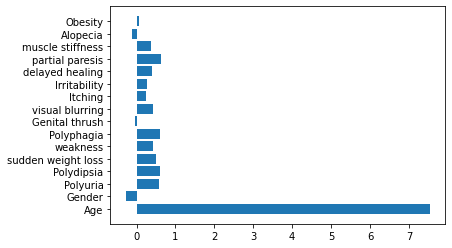

In [282]:
X1 = X_train[assigned_cluster ==1].mean()
X0 = X_train[assigned_cluster ==0].mean()
plt.barh((X0-X1).index,X0-X1)

Above chart is no suprise. We have previously concluded in EDA notebook that -
<br>Positive correlation includes Polyuria/Polydipsia/Sudden weight loss/Weakness/Polyphagia/visual <br>blurring/Irritability/partial paresis/muscle stiffness
<br>Negative correlation includes Genital thrush/Alopecia
<br>No correlation includes Itching/delayed heaing/obesity
There are some level of differences since the clusters assigned are used instead of the actual class of Diabetes. But in general we can see the overall direction are pretty consistent

4. Initial Training of models

In [309]:
y_test['class']

205    0.0
363    1.0
266    1.0
26     1.0
24     1.0
      ... 
478    0.0
508    0.0
465    0.0
214    0.0
351    0.0
Name: class, Length: 104, dtype: float64

In [346]:
# Random Forest 
rf = RandomForestClassifier(max_depth=3)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('confusion_matrix:', confusion_matrix(y_test,y_pred))
print('f1_score:',f1_score(y_test,y_pred))
print('accuracy_score:',accuracy_score(y_test,y_pred))
print('precision_score:',precision_score(y_test,y_pred))
print('recall_score:',recall_score(y_test,y_pred))
#classification_report(y_test,y_pred)

confusion_matrix: [[44  5]
 [ 4 51]]
f1_score: 0.918918918918919
accuracy_score: 0.9134615384615384
precision_score: 0.9107142857142857
recall_score: 0.9272727272727272


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


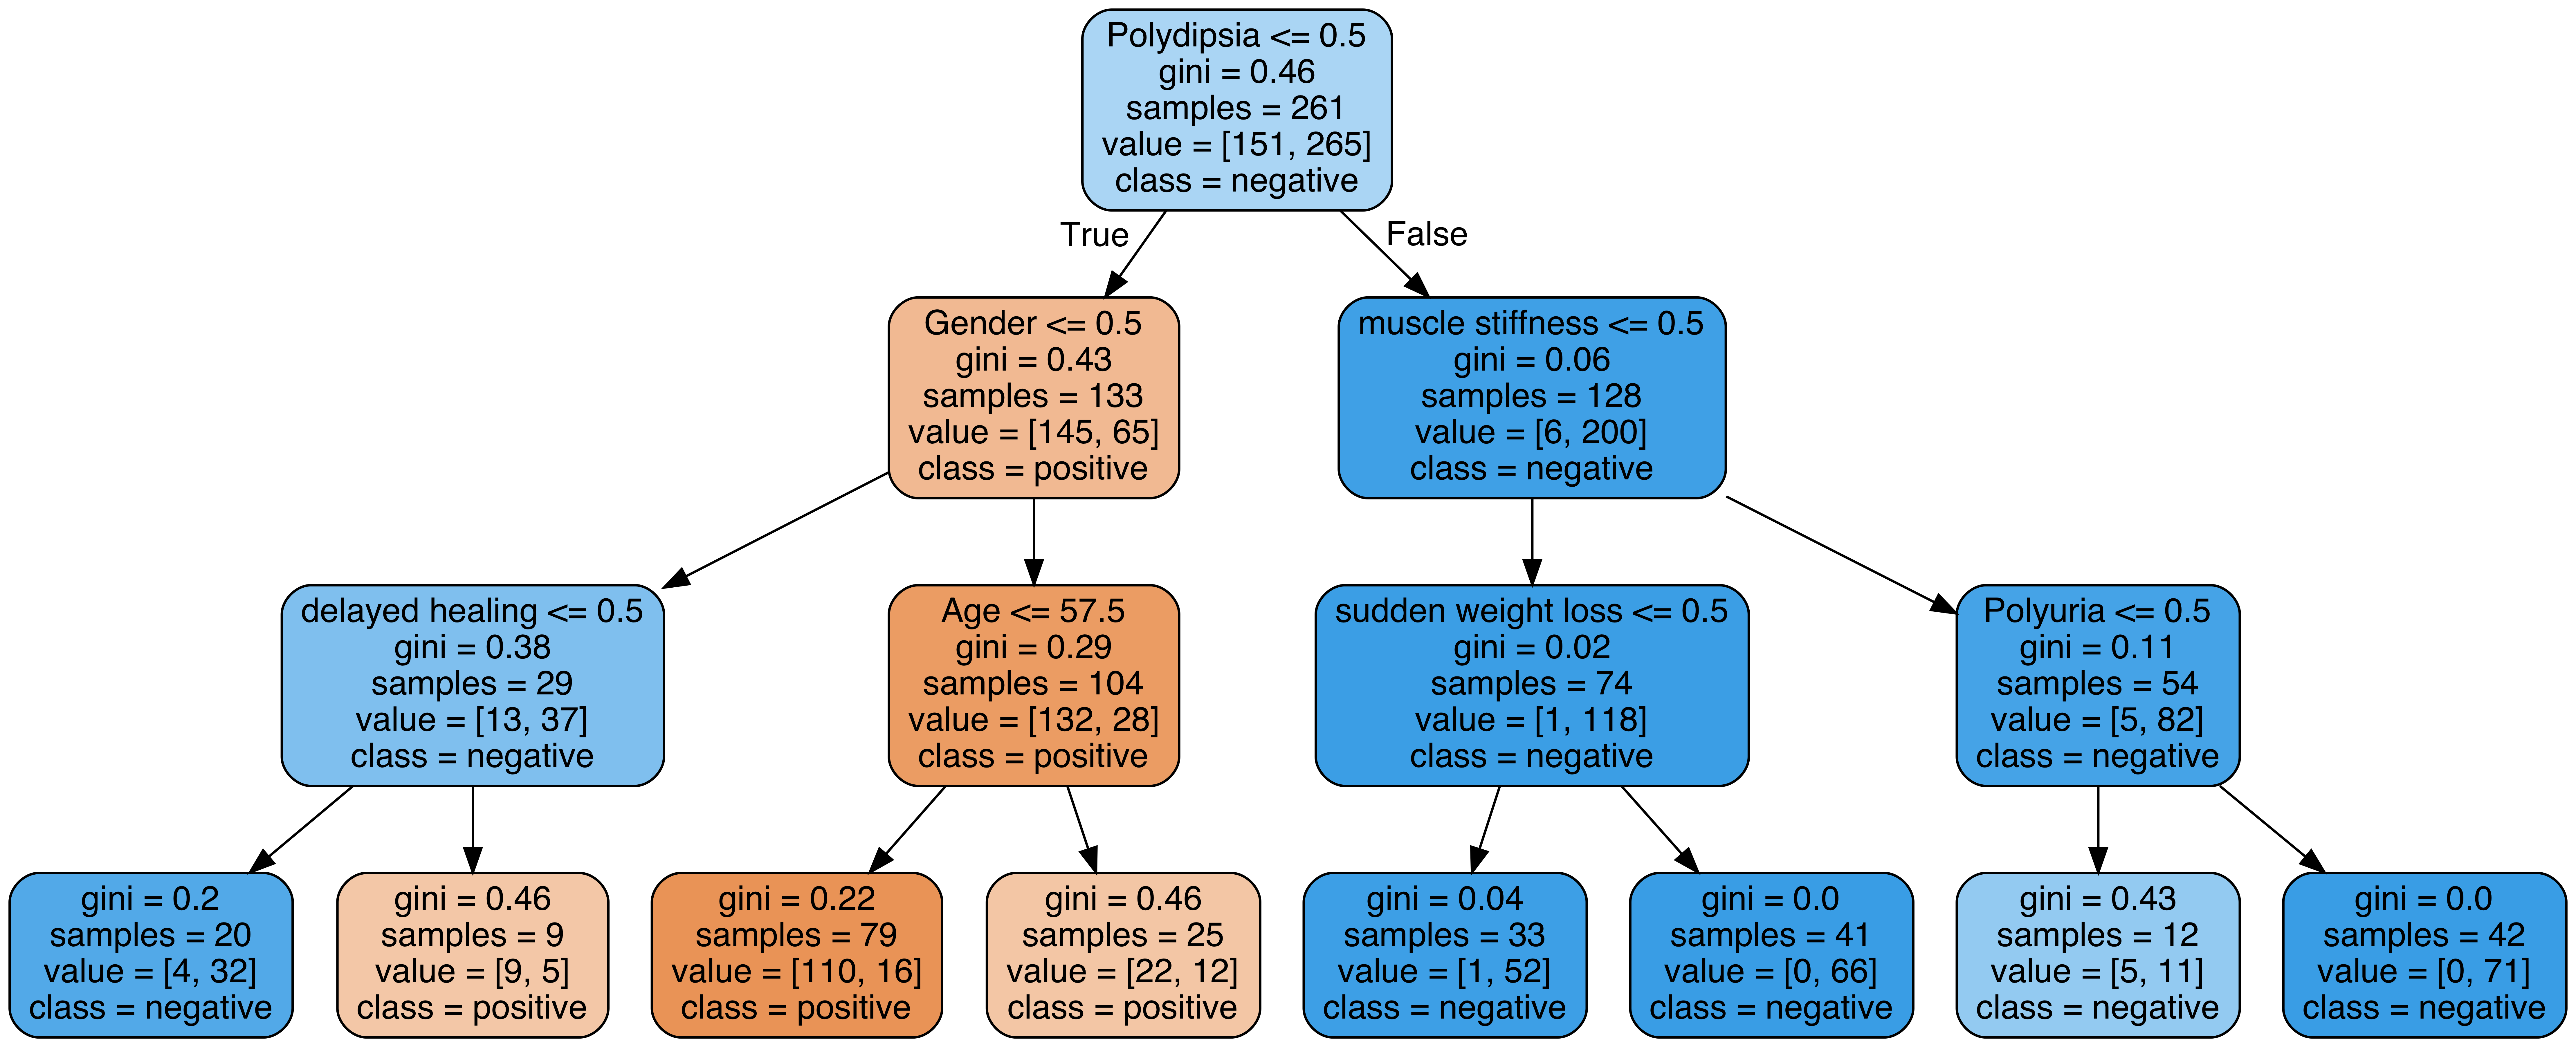

In [347]:
estimator = rf.estimators_[0]
export_graphviz(estimator, out_file='../reports/figures/tree.dot', 
                feature_names = X_test.columns,
                class_names = ['positive','negative'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)
from subprocess import call
call(['dot', '-Tpng', '../reports/figures/tree.dot', '-o', '../reports/figures/tree.png', '-Gdpi=600'])


from IPython.display import Image
Image(filename = '../reports/figures/tree.png')

Using a 3-depth random forest, we are able to reach an accuracy of 91%, so much higher and the unsupervised approach we were experimenting based on KMeans clustering.
<br> In the next notebook we will look to find the best model based on cross validation.